In [1]:
import os, csv, math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
results_path_256 = './3500_results/256GB/graphs/results.csv'
results_path_8 = './3500_results/8GB/graphs/results.csv'
results_path_4 = './3500_results/4GB/graphs/results.csv'

   run_ref     model  process_time  preprocess_time   read_time  write_time  \
0        3  baseline    909.907476         0.000000  207.139655  693.089507   
1        1  baseline    581.302264         0.000000  262.960441  317.979834   
2        3      keep    505.873381         3.976405  269.619133   80.419943   
3        5      keep    378.921909         0.075341  272.095709   50.161825   
4        1      keep    384.355336         0.015230  225.374247   55.059827   

    nb_seeks    overhead  
0  196337576    9.678313  
1   73500112    0.361989  
2       7144  151.857901  
3       1316   56.589033  
4        356  103.906032  
   run_ref     model  process_time  preprocess_time   read_time  write_time  \
0        4      keep    760.375015         8.056536  409.708791  136.982041   
1        1      keep    353.979367         0.015043  240.009593   49.993392   
2        4  baseline   1338.395106         0.000000  309.873481  951.012802   
3        6      keep    358.482591         0.36

/home/glatard/venvs/jupyter/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-3-f837700cdc8b>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ref_names)
/home/glatard/venvs/jupyter/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-3-f837700cdc8b>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ref_names)
/home/glatard/venvs/jupyter/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-3-f837700cdc8b>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ref_na

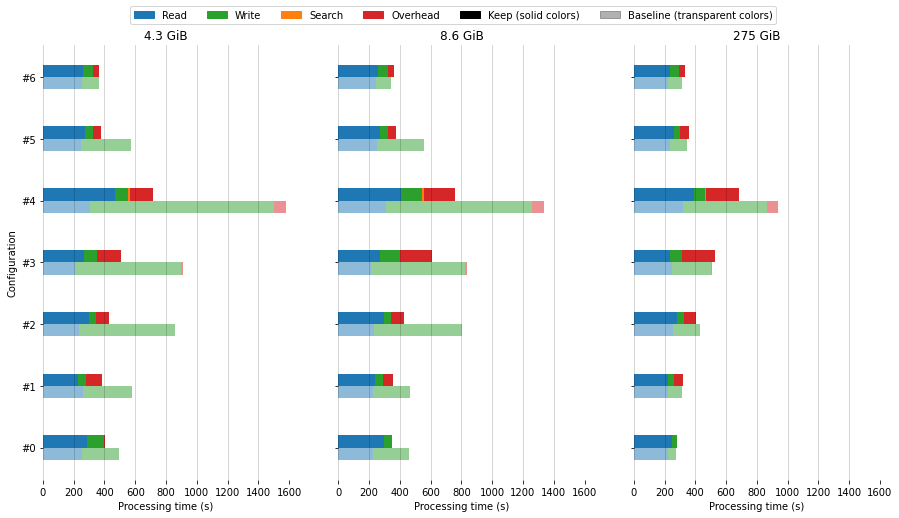

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 8), sharey=True)
for ax in (ax1, ax2, ax3):
    ax.grid(True, axis='x', which='major', color='black', alpha=0.2, zorder=0)


def compute_graph(results_path, ax, title, legend=False, first=False):
    df = pd.read_csv(results_path)
    df_seeks = pd.read_csv(results_path)

    # preprocessing
    df = df.drop(columns=['max_voxels', 'success', 'case_name', 'Unnamed: 0'])
    df['nb_seeks'] = df['outfile_openings'] + df['outfile_seeks'] + df['infile_openings'] + df['infile_seeks']
    df = df.drop(columns=['outfile_openings', 'outfile_seeks', 'infile_openings', 'infile_seeks'])
    df['overhead'] = df['process_time'] - df['preprocess_time'] - df['read_time'] - df['write_time']

    
    
    print(df.head())
    
    references = df["run_ref"].unique()
    models = df["model"].unique()

    # df splits
    df = df.sort_values(["model", "run_ref"])

    df_keep = df.loc[df["model"]=="keep"]
    keep_means = df_keep.groupby('run_ref').mean()
    keep_stds = df_keep.groupby('run_ref').std()

    df_baseline = df.loc[df["model"]=="baseline"]
    baseline_means = df_baseline.groupby('run_ref').mean()
    baseline_stds = df_baseline.groupby('run_ref').std()
    
    x = np.arange(len(references))  # the label locations
    baseline_prepross_bottom = baseline_means["write_time"] + baseline_means['read_time']
    baseline_overhead_bottom = baseline_prepross_bottom + baseline_means['preprocess_time']
    keep_prepross_bottom = keep_means["write_time"] + keep_means['read_time']
    keep_overhead_bottom = keep_prepross_bottom + keep_means['preprocess_time']
    
    width = 0.20  # the width of the bars
    width_step = [width /2, width /2]
    
    _ = ax.barh(x - width_step[0], baseline_means["read_time"], width, yerr=baseline_stds['read_time'], label='read time (baseline)', color=['tab:blue'], alpha=0.5)
    _ = ax.barh(x - width_step[0], baseline_means["write_time"], width, left=baseline_means["read_time"], yerr=baseline_stds['write_time'], label='write time (baseline)', color=['tab:green'], alpha=0.5)
    _ = ax.barh(x - width_step[0], baseline_means["preprocess_time"], width, left=baseline_prepross_bottom, yerr=baseline_stds['preprocess_time'], label='preprocessing time (baseline)', color=['tab:orange'], alpha=0.5)
    _ = ax.barh(x - width_step[0], baseline_means["overhead"], width, left=baseline_overhead_bottom, yerr=baseline_stds['overhead'], label='overhead time (baseline)', color=['tab:red'], alpha=0.5)

    bar1 = ax.barh(x + width_step[1], keep_means["read_time"], width, yerr=keep_stds['read_time'], label='read time (keep)', color=['tab:blue'])
    bar2 = ax.barh(x + width_step[1], keep_means["write_time"], width, left=keep_means['read_time'], yerr=keep_stds['write_time'], label='write time (keep)', color=['tab:green'])
    bar3 = ax.barh(x + width_step[1], keep_means["preprocess_time"], width, left=keep_prepross_bottom, yerr=keep_stds['preprocess_time'], label='preprocessing time (keep)', color=['tab:orange'])
    bar4 = ax.barh(x + width_step[1], keep_means["overhead"], width, left=keep_overhead_bottom, yerr=keep_stds['overhead'], label='overhead time (keep)', color=['tab:red'])

    ax.set_xlabel('Processing time (s)')
    if first:
        ax.set_ylabel('Configuration')
    ax.set_title(title)
    # ax.set_xticks(x)
    
    ref_names = sorted(references)
    ref_names = [""] + list(map(lambda x: "#" + str(x), ref_names))
    
    ax.set_yticklabels(ref_names)
    ax.set_xlim(right=1600) #-> for 3500 img results
    
    
    return 

compute_graph(results_path_4, ax1, '4.3 GiB', legend=False, first=True)
compute_graph(results_path_8, ax2, '8.6 GiB', legend=False)
compute_graph(results_path_256, ax3, '275 GiB', legend=True)

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
    
import matplotlib.patches as mpatches
p1 = mpatches.Patch(color='tab:blue', label='Read')
p2 = mpatches.Patch(color='tab:green', label='Write')
p3 = mpatches.Patch(color='tab:orange', label='Search')
p4 = mpatches.Patch(color='tab:red', label='Overhead')
p5 = mpatches.Patch(color='black', label='Keep (solid colors)')
p6 = mpatches.Patch(color='black', alpha=0.3, label='Baseline (transparent colors)')
plt.legend(handles=[p1, p2, p3, p4, p5, p6], ncol=6, bbox_to_anchor=(0.6, 1.1))
plt.savefig('../../rechunk-paper/figures/time_3500.pdf', bbox_inches="tight")
